In [1]:
from scipy import io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from rlx.ml import Batches, show_image_mosaic
from rlx.utils import humanbytes
from time import time
import tflearn, psutil, gc
import h5py
from datetime import datetime
%matplotlib inline

/opt/miniconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/opt/miniconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.normalization import local_response_normalization
from tflearn.layers.estimator import regression
import tflearn
import tensorflow as tf
print "free mem", humanbytes(psutil.virtual_memory().free)

free mem 1.18 GB


## Exercise 1: Load CIFAR-10 and create `info` data

### Part A: Load CIFATR10
download the dataset from https://www.cs.toronto.edu/~kriz/cifar.html and create a function to return selected batches 


In [3]:
def load_cifar(batches = [1,2,3,4,5]):
    
    cifar10_dir ="mnt/cifar-10-batches-py/cifar-10-batches-py/"   # this is where you downloaded CIFAR10
    data_cifar={"data":np.r_, "labels":[]}
    
    def unpickle(file):
        import cPickle
        with open(file, 'rb') as fo:
            dict = cPickle.load(fo)
        return dict
    
    data1=unpickle(cifar10_dir+"data_batch_1")
    imgs=data1["data"]
    labels=data1["labels"]
    
    if len(batches)>1:
            for batch in batches[1:]:
                data2=unpickle(cifar10_dir+"data_batch_%d"%batch)
                data_imgs=data2["data"]
                data_labels=data2["labels"]
                labels+=data_labels
                imgs=np.concatenate((imgs,data_imgs))
                
                
    def onehot_labels(labels):
        return np.eye(10)[labels]
        
    imgs   = imgs.reshape(-1,3,32,32).transpose(0,2,3,1)
    labels = np.r_[labels]
    ohlabs = onehot_labels(labels)
    return imgs, labels, ohlabs


def train_test_split(imgs, labels, ohlabs, train_pct=.8, shuffle=True):
    
    train_size=int(len(imgs)*train_pct)
    print(train_size)
    
    if shuffle:
        idxs=np.random.permutation(range(len(imgs)))
        
    else:
        idxs=np.arange((len(imgs)))
        
    train_imgs   = imgs[idxs[:train_size]]
    train_ohlabs = ohlabs[idxs[:train_size]]
    train_labels = labels[idxs[:train_size]]

    test_imgs   = imgs[idxs[train_size:]]
    test_ohlabs = ohlabs[idxs[train_size:]]
    test_labels = labels[idxs[train_size:]]

    return train_imgs, train_labels, train_ohlabs, test_imgs, test_labels, test_ohlabs

print "free mem", humanbytes(psutil.virtual_memory().free)

free mem 1.18 GB


** we will use only batch 1**. create variables as in previous problemsets and create additional **INFO** variables with the new information.

data shapes must be as follows:

        imgs         (10000, 32, 32, 3)
        labels       (10000,)
        onehot       (10000, 10)
        train_imgs   (8000, 32, 32, 3)
        train_labels (8000,)
        train_ohlabs (8000, 10)
        train_info   (8000,)
        test_imgs    (2000, 32, 32, 3)
        test_labels  (2000,)
        test_ohlabs  (2000, 10)
        test_info    (2000,)

In [4]:
imgs, labels, ohlabs = load_cifar(batches = [1,2,3,4,5])
d = train_test_split(imgs, labels, ohlabs,)
train_imgs, train_labels, train_ohlabs, test_imgs, test_labels, test_ohlabs = d

print "imgs  ", imgs.shape
print "labels", labels.shape
print "onehot", ohlabs.shape
print "train_imgs  ", train_imgs.shape
print "train_labels", train_labels.shape
print "train_ohlabs", train_ohlabs.shape
print "test_imgs   ", test_imgs.shape
print "test_labels ", test_labels.shape
print "test_ohlabs ", test_ohlabs.shape
gc.collect()
print "free mem", humanbytes(psutil.virtual_memory().free)

40000
imgs   (50000, 32, 32, 3)
labels (50000,)
onehot (50000, 10)
train_imgs   (40000, 32, 32, 3)
train_labels (40000,)
train_ohlabs (40000, 10)
test_imgs    (10000, 32, 32, 3)
test_labels  (10000,)
test_ohlabs  (10000, 10)
free mem 755.23 MB


### Part B: Generate info

we will add **ONE NEURON** at the last **fully connected layer** with the following values:

- **+1** if the image corresponds to a **LIVING THING**
- **-1** otherwise

complete the following function to transform the `labels` numpy array passed as argument using this convention, such as

    [3, 1, 7, 9] --> [1, -1, 1, -1]

In [5]:
labcode= np.r_[[  0    ,   1,     2,      3,     4,      5,      6,      7,       8,      9   ]]
cnames = np.r_[["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "boat", "truck"]]
info   = np.r_[[ -1,      -1,     1,      1,     1,      1,      1,      1,       -1,     -1  ]]

def get_info(labels):
    
    labels_info = info[[labels]]
    
    return labels_info

so now we create the info variables for train and test

In [6]:
train_info = get_info(train_labels)
test_info  = get_info(test_labels)

print train_info.shape


(40000,)


## Exercise 2: Build `tflearn` model

use the same network as in the previous problemset **BUT** add an additional input neuron at OUTPUT layer:

| layer   | input_size  | output_size | filter_size  | stride | n_filters |activation| var sizes  | params |
| ------- |:-----------:|:-----------:|:------------:|:------:|:---------:|:--------:|:--------------:| |
| conv1   | 32x32x3     | 32x32x15     | 5x5          |1       | 15        | relu     | W1 = [5,5,3,15]<br/> b = [15]|-|
| conv2   | 32x32x15    | 16x16x18    | 5x5          |2       | 18        | relu     | W2 = [5,5,15,18]<br/> b = [18]|-|
| conv3   | 16x16x18    | 8x8x20      | 3x3          |2       | 20        | relu     | W3 = [3,3,18,20]<br/> b =[20]|-|
| maxpool | 8x8x20      | 4x4x20      |              |        |           |          | | k = 2 |
| fc      | 4x4x20      |    100      |              |        |           | relu     | W4 = [320,100]<br/>b=[100]|-|
| dropout | 100         |   100       |              |        |           |          | | pkeep = .75 |
| output **+ INFO**  | **101**         |   10        |              |        |           | softmax  | W5 = [**101**,10]<br/>b=[10]|-|


In [7]:
def get_TF_graph(pkeep=.075):
    tf.reset_default_graph()
    
    with tf.name_scope("data"):
        X      = tf.placeholder(tf.float32, [None, 32, 32, 3]) 
        X_info = tf.placeholder(tf.float32, [None, 1])
        
        Y      = tf.placeholder(tf.float32, [None, 10])
        network1 = tf.reshape(X, [-1, 32, 32, 3])
    
    with tf.name_scope("layers"):
        num_classes=10
        network2 = conv_2d(network1, 15, 5, strides=1, activation='relu', name="conv1", padding="SAME")
        network3 = conv_2d(network2, 18, 5, strides=2, activation='relu', name="conv2", padding="SAME")
        network4 = conv_2d(network3, 20, 3, strides=2, activation='relu', name="conv3", padding="SAME")
        network5 = max_pool_2d(network4, 2, strides=2, name="conv3", padding="SAME")
        network6 = fully_connected(network5, 100, activation='relu', name='fc1')
        network7 = dropout(network6, pkeep, name='dropout')
        network8 = tf.concat((X_info, network7), axis=1)
        y_hat = fully_connected(network8, num_classes, activation='softmax', name='fc2')

    with tf.name_scope("loss"):
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=y_hat, labels=Y)
        loss          = tf.reduce_mean(cross_entropy)*100

    with tf.name_scope("accuracy"):
        correct_pred = tf.equal(tf.argmax(y_hat, 1), tf.argmax(Y, 1))
        accuracy     = tf.reduce_mean(tf.cast(correct_pred, tf.float32))    
    
    with tf.name_scope("optimizer"):
        train_step = tf.train.AdamOptimizer().minimize(loss)
        
    return X, Y, X_info, y_hat, loss, train_step, accuracy, network2

print "free mem", humanbytes(psutil.virtual_memory().free)

free mem 754.95 MB


In [8]:
X, Y, X_info, y_hat, loss, train_step, accuracy, network2 = get_TF_graph()
vars = {i.name:i for i in tflearn.variables.get_all_trainable_variable()}
vars

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


{u'conv1/W:0': <tf.Variable 'conv1/W:0' shape=(5, 5, 3, 15) dtype=float32_ref>,
 u'conv1/b:0': <tf.Variable 'conv1/b:0' shape=(15,) dtype=float32_ref>,
 u'conv2/W:0': <tf.Variable 'conv2/W:0' shape=(5, 5, 15, 18) dtype=float32_ref>,
 u'conv2/b:0': <tf.Variable 'conv2/b:0' shape=(18,) dtype=float32_ref>,
 u'conv3/W:0': <tf.Variable 'conv3/W:0' shape=(3, 3, 18, 20) dtype=float32_ref>,
 u'conv3/b:0': <tf.Variable 'conv3/b:0' shape=(20,) dtype=float32_ref>,
 u'fc1/W:0': <tf.Variable 'fc1/W:0' shape=(320, 100) dtype=float32_ref>,
 u'fc1/b:0': <tf.Variable 'fc1/b:0' shape=(100,) dtype=float32_ref>,
 u'fc2/W:0': <tf.Variable 'fc2/W:0' shape=(101, 10) dtype=float32_ref>,
 u'fc2/b:0': <tf.Variable 'fc2/b:0' shape=(10,) dtype=float32_ref>}

## Exercise 3: implement optimization loop

In [9]:
model_name = "cnn_cifar10_info_" + datetime.now().strftime("%m-%d_%H:%M")
print model_name

cnn_cifar10_info_05-04_11:46


In [10]:
def fit (X, Y, X_info,
         X_train, y_train, X_train_info, X_test, y_test, X_test_info,
         model_name, loss, train_step, accuracy, 
         batch_size, n_epochs, log_freq):
    
    saver = tf.train.Saver()
    
    # Initialize the variables (i.e. assign their default value)
    init = tf.global_variables_initializer()
    log_train, log_test = [], []

    # Start training
    from rlx.ml import Batches
    from time import time

    with tf.Session() as sess:
        from datetime import datetime

        model_name = model_name + "_" + datetime.now().strftime("%Y-%m-%d_%H:%M")
        
        sess.run(init)

        step = 1
        t1 = time()
        for epoch in range(1,n_epochs+1):
            ndata = 0
            for batch_X, batch_X_info, batch_y in Batches([X_train, X_train_info, y_train], 
                                                          batch_size=batch_size, 
                                                          n_epochs=1, shuffle=True).get():
                ndata += len(batch_X)
                # Run optimization 
                train_acc, _ = sess.run([accuracy, train_step], 
                                         feed_dict={X: batch_X, Y: batch_y,
                                                    X_info: batch_X_info.reshape(-1,1)})
                t2 = time()
                log_train.append([step, t2-t1, train_acc])
                print "\repoch %3d/%d step %5d: train acc: %.4f, time: %.3f segs, %7d/%d"%(epoch, n_epochs, step, train_acc, (t2-t1), ndata, len(train_imgs)),
                if step%log_freq==0:
                    idxs = np.random.permutation(range(len(X_test)))[:1000] 
                                        
                    test_acc = sess.run(accuracy, feed_dict = {X: X_test[idxs], 
                                                               Y: y_test[idxs],
                                                               X_info: X_test_info[idxs].reshape(-1,1)})

                    print "\repoch %3d/%d step %5d: train acc: %.4f, test acc: %.4f, time: %.3f segs, %d data items"%(epoch, n_epochs, step, train_acc, test_acc, (t2-t1), ndata)
                    log_test.append([step, t2-t1, test_acc])
                    saver.save(sess, "models/"+model_name+".tf")

                step += 1

        print("Optimization Finished!")

        # Calculate accuracy for test images by batches (for low memory)
        test_acc = 0
        for batch_X, batch_X_info, batch_y in Batches([X_test, X_test_info, y_test], batch_size=batch_size, n_epochs=1).get():
            test_acc += sess.run(accuracy, feed_dict={X: batch_X, 
                                                      Y: batch_y, 
                                                      X_info: batch_X_info.reshape(-1,1)})*len(batch_X)/len(X_test)
            
        print("Testing Accuracy:", test_acc)

        saver.save(sess, "models/"+model_name+".tf")
        log_train = pd.DataFrame(log_train, columns=["step", "time", "accuracy"])
        log_test  = pd.DataFrame(log_test, columns=["step", "time", "accuracy"])
    return log_train, log_test, model_name
    

def plot_results(log_train, log_test):
    k = log_train.rolling(window=10).mean().dropna()
    plt.plot(k.time, k.accuracy, color="blue", lw=2, label="train")
    plt.plot(log_test.time, log_test.accuracy, color="red",lw=2, label="test")
    plt.legend(loc="center left", bbox_to_anchor=(1,.5))
    plt.plot(log_train.time, log_train.accuracy, alpha=.3, color="blue")
    plt.grid()
    plt.xlabel("elapsed time (secs)")
    plt.ylabel("accuracy")
    plt.axhline(0.5, color="black")
    plt.xlim(0,log_train.time.max()+1)
    plt.title("final train_acc=%.4f, test_acc=%.4f"%(log_train.accuracy.values[-1], log_test.accuracy.values[-1]))

### train your model !!!

In [ ]:
X, Y, X_info, y_hat, loss, train_step, accuracy, network2 = get_TF_graph()
print "free mem", humanbytes(psutil.virtual_memory().free)

free mem 742.35 MB


In [ ]:
log_train, log_test, model_name = fit(X, Y, X_info,
                                      train_imgs, train_ohlabs, train_info,
                                      test_imgs, test_ohlabs, test_info,
                                      "extended_cnn_mnist", loss, train_step, accuracy,
                                      batch_size=100, n_epochs=20, log_freq=400)

plot_results(log_train, log_test)
print "free mem", humanbytes(psutil.virtual_memory().free)

epoch   1/20 step   400: train acc: 0.3600, test acc: 0.3550, time: 763.751 segs, 40000 data items                                                                                                                                                                                                                                                                                                                                                                                         
epoch   2/20 step   800: train acc: 0.3600, test acc: 0.3680, time: 1439.305 segs, 40000 data items                                                                                                                                                                                                                                                                                                                                                                                          
epoch   3/20 step  1200: train acc: 0.3800, te

## Exercise 4: visualize filters, sample misses and activations

In [18]:
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, "models/"+model_name+".tf")    
    C1_activations, test_preds, w1= sess.run([network2, y_hat, network2.W], feed_dict={X:test_imgs, X_info: test_info.reshape(-1,1)})

INFO:tensorflow:Restoring parameters from models/extended_cnn_mnist_2018-04-25_22:14.tf


In [20]:
print "Show Confusion Matrix"
preds = np.argmax(test_preds, axis=1)
print preds.shape, test_labels.shape
print np.mean(test_labels==preds)
from rlx.ml import confusion_matrix
confusion_matrix(test_labels, preds)

Show Confusion Matrix
(10000,) (10000,)
0.5974


predicted,0,1,2,3,4,5,6,7,8,9
true,,,,,,,,,,
0,696,27,6,5,3,1,7,10,105,92
1,44,621,3,6,0,0,7,2,71,262
2,5,11,561,91,110,51,137,56,15,9
3,3,13,128,447,48,113,126,63,11,21
4,3,10,164,90,453,35,118,106,15,12
5,1,9,106,262,60,342,87,94,5,17
6,2,13,66,109,41,27,716,20,5,10
7,4,8,61,99,111,66,33,627,4,20
8,136,40,2,7,1,1,0,0,718,86


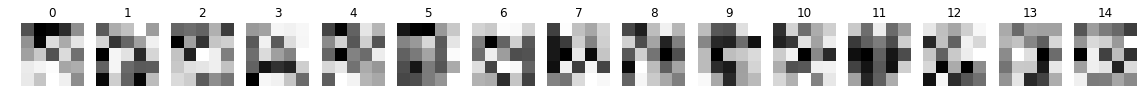

In [21]:
def display_imgs(w, figsize=(20,3)):
    plt.figure(figsize=figsize)
    for i in range(w.shape[-1]):
        plt.subplot(1,w.shape[-1],i+1)
        plt.imshow(w[:,:,i], cmap = plt.cm.Greys_r, interpolation="none")
        plt.axis("off")
        plt.title(i)
        
display_imgs(w1[:,:,0,:])

SHOW SOME MISSES


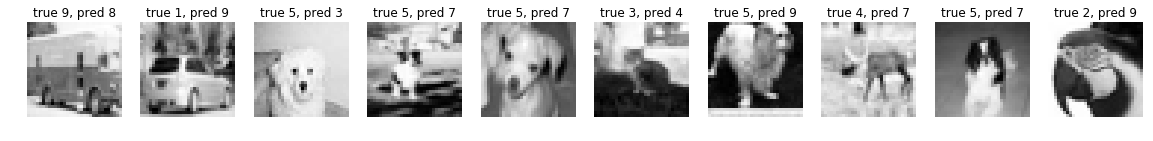

In [132]:
print "SHOW SOME MISSES"
misses = np.argwhere(test_labels != preds)[:,0]
idxs = np.random.permutation(misses)[:10]
plt.figure(figsize=(20,3))
for i,idx in enumerate(idxs):
    plt.subplot(1,10,i+1)
    plt.imshow(test_imgs[idx][:,:,0], cmap=plt.cm.Greys_r)
    plt.axis("off")
    plt.title("true %d, pred %d"%(test_labels[idx], preds[idx]))

show conv1 activations for a random image


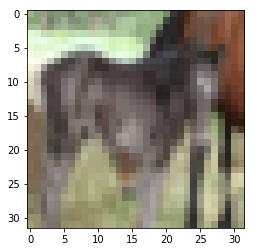

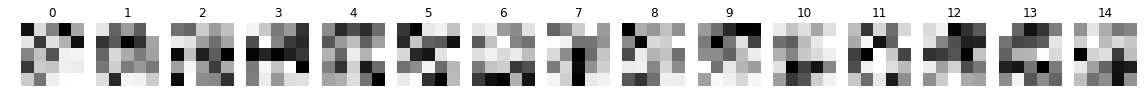

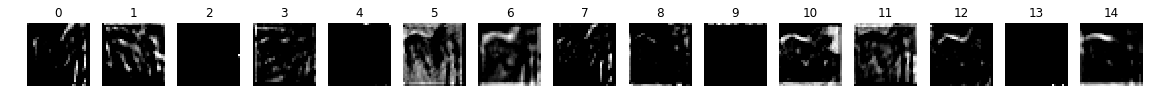

In [134]:
print "show conv1 activations for a random image"
i = np.random.randint(len(test_imgs))

plt.imshow(test_imgs[i])
display_imgs(w1[:,:,0,:])
display_imgs(C1_activations[i])
